# Project 10 - Energy Consumption Prediction - Data Cleaning and EDA

- Course Name :         Applied Machine Learning
- Course instructor :   Sohail Tehranipour
- Student Name :        Afshin Masoudi Ashtiani
- Project 10 :           Energy Consumption Prediction
- Date :                September 2024
- Files :               1/2

## Step 1 : Install required libraries

In [1]:
%pip install numpy pandas
%pip install matplotlib seaborn plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Step 2 : Import required libraries

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Warnings
import warnings
warnings.filterwarnings('ignore')

## Step 3 : Load and prepare the dataset (Energy Consumption)

- ### Load the data

In [3]:
data_dir = r'F:/Python_Projects/AppliedMechineLearningWithPython/Project_10_Energy_Consumption_Prediction/datasets'
# data_dir = '/content/drive/My Drive/Applied Machine Learning/Project 10 : Energy Consumption Prediction/datasets'

data_path = os.path.join(data_dir, 'PJME_hourly.csv')
energy_df = pd.read_csv(data_path)

energy_df.info()
energy_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


Datetime  PJME_MW
93288   2012-05-10 23:00:00  27196.0
110992  2014-05-03 17:00:00  25436.0
107747  2014-09-15 12:00:00  29985.0
26668   2005-12-16 11:00:00  36606.0
111972  2014-03-23 13:00:00  29588.0

- ### Prepare the data

In [4]:
# Convert 'Datetime' feature to datetime
energy_df.Datetime = pd.to_datetime(energy_df.Datetime)
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [5]:
# Set 'Datetime' feature as index
# energy_df = energy_df.set_index('Datetime')
# energy_df.sample(5)

## Step 4 : Data Cleaning

- ### Handle **missing values**

In [6]:
energy_df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [7]:
# Handle Missing Values
print(f'> Shape of energy dataset before handling missing values: {energy_df.shape}')
energy_df.dropna(inplace=True)
print(f'> Shape of energy dataset after  handling missing values: {energy_df.shape}')

> Shape of energy dataset before handling missing values: (145366, 2)
> Shape of energy dataset after  handling missing values: (145366, 2)


- ### Handle **outliers**

In [8]:
energy_df.describe()

Datetime        PJME_MW
count                         145366  145366.000000
mean   2010-04-18 03:25:25.999202048   32080.222831
min              2002-01-01 01:00:00   14544.000000
25%              2006-02-23 14:15:00   27573.000000
50%              2010-04-18 04:30:00   31421.000000
75%              2014-06-10 18:45:00   35650.000000
max              2018-08-03 00:00:00   62009.000000
std                              NaN    6464.012166

- Visualize the outliers

In [9]:
def plot_bell_curve(data: pd.DataFrame, feature_name: str):
    # Calculate the mean and standard deviation
    mean = data[feature_name].mean()
    std_dev = data[feature_name].std()

    # Create the histogram
    fig = px.histogram(data, x=feature_name, nbins=500, 
                       title="Bell Curve", 
                       histnorm='probability density')  # Normalize for probability density
    fig.update_traces(marker=dict(color="blue", opacity=0.5))

    # Create the bell curve using a range of x values
    x_values = np.linspace(data[feature_name].min(), data[feature_name].max(), 1000)
    y_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean) / std_dev) ** 2)

    # Add bell curve to the existing figure
    fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', 
                             name='Bell Curve', line=dict(color='red', width=2)))

    # Update layout titles
    fig.update_layout(
        title='Hourly Energy Consumption with Bell Curve',
        xaxis_title=feature_name,
        yaxis_title="Density",
        template='plotly',
        showlegend=True
    )

    fig.show()

def plot_box(data: pd.DataFrame, feature_name: str):
    """Plots a box plot for the specified feature in the given DataFrame."""
    
    # Create a box plot
    fig = px.box(data, x=feature_name, points="all")  # Show all points to visualize outliers
    
    # Add titles and labels
    fig.update_layout(
        title=f'Box Plot of {feature_name}',
        xaxis_title=feature_name,
        yaxis_title='Value',
        template='plotly'
    )

    # Show the figure
    fig.show()

In [10]:
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [11]:
plot_bell_curve(energy_df, 'PJME_MW')
plot_box(energy_df, 'PJME_MW')

In [12]:
def calculate_dates(date_str: str):
    """Generate date ranges based on the input date."""
    date_parts = list(map(int, date_str.split('-')))
    start_date = pd.Timestamp(year=date_parts[2], month=date_parts[0], day=date_parts[1])
    return {
        'one_year': start_date + pd.DateOffset(years=1),
        'one_month': start_date + pd.DateOffset(months=1),
        'one_day': start_date + pd.DateOffset(days=1),
    }

def display_hourly_energy_consumption(data: pd.DataFrame, date: str = '06-01-2012'):
    years = (data.iloc[-1, 0] - data.iloc[0, 0]).days // 365

    date_ranges = calculate_dates(date)

    fig, axs = plt.subplots(4, 1, figsize=(26, 4 * 8))  # Adjusted figsize for clarity

    # Main Data Plot
    data.plot(x='Datetime', y='PJME_MW', style='o', ax=axs[0], color=color_pal[0])
    axs[0].set_title(f'Hourly Energy Consumption in {years} years')
    axs[0].set_ylabel('PJME_MW')

    # Iterating over each time frame to create plots
    timeframes = [('Year', date_ranges['one_year'], color_pal[1]),
                  ('Month', date_ranges['one_month'], color_pal[2]),
                  ('Day', date_ranges['one_day'], color_pal[3])]
    
    for ax, (label, end_date, color) in zip(axs[1:], timeframes):
        time_frame_data = data[(data.Datetime > date) & (data.Datetime < end_date)]
        time_frame_data.plot(x='Datetime', y='PJME_MW', style='o', ax=ax, color=color)
        ax.set_title(f'Hourly Energy Consumption in a {label.lower()}')
        ax.set_ylabel('PJME_MW')
        ax.set_xlabel('Date' if label.lower() != 'day' else 'Time')
    
    plt.tight_layout()  # Adjusts subplot params to give specified padding
    plt.show()

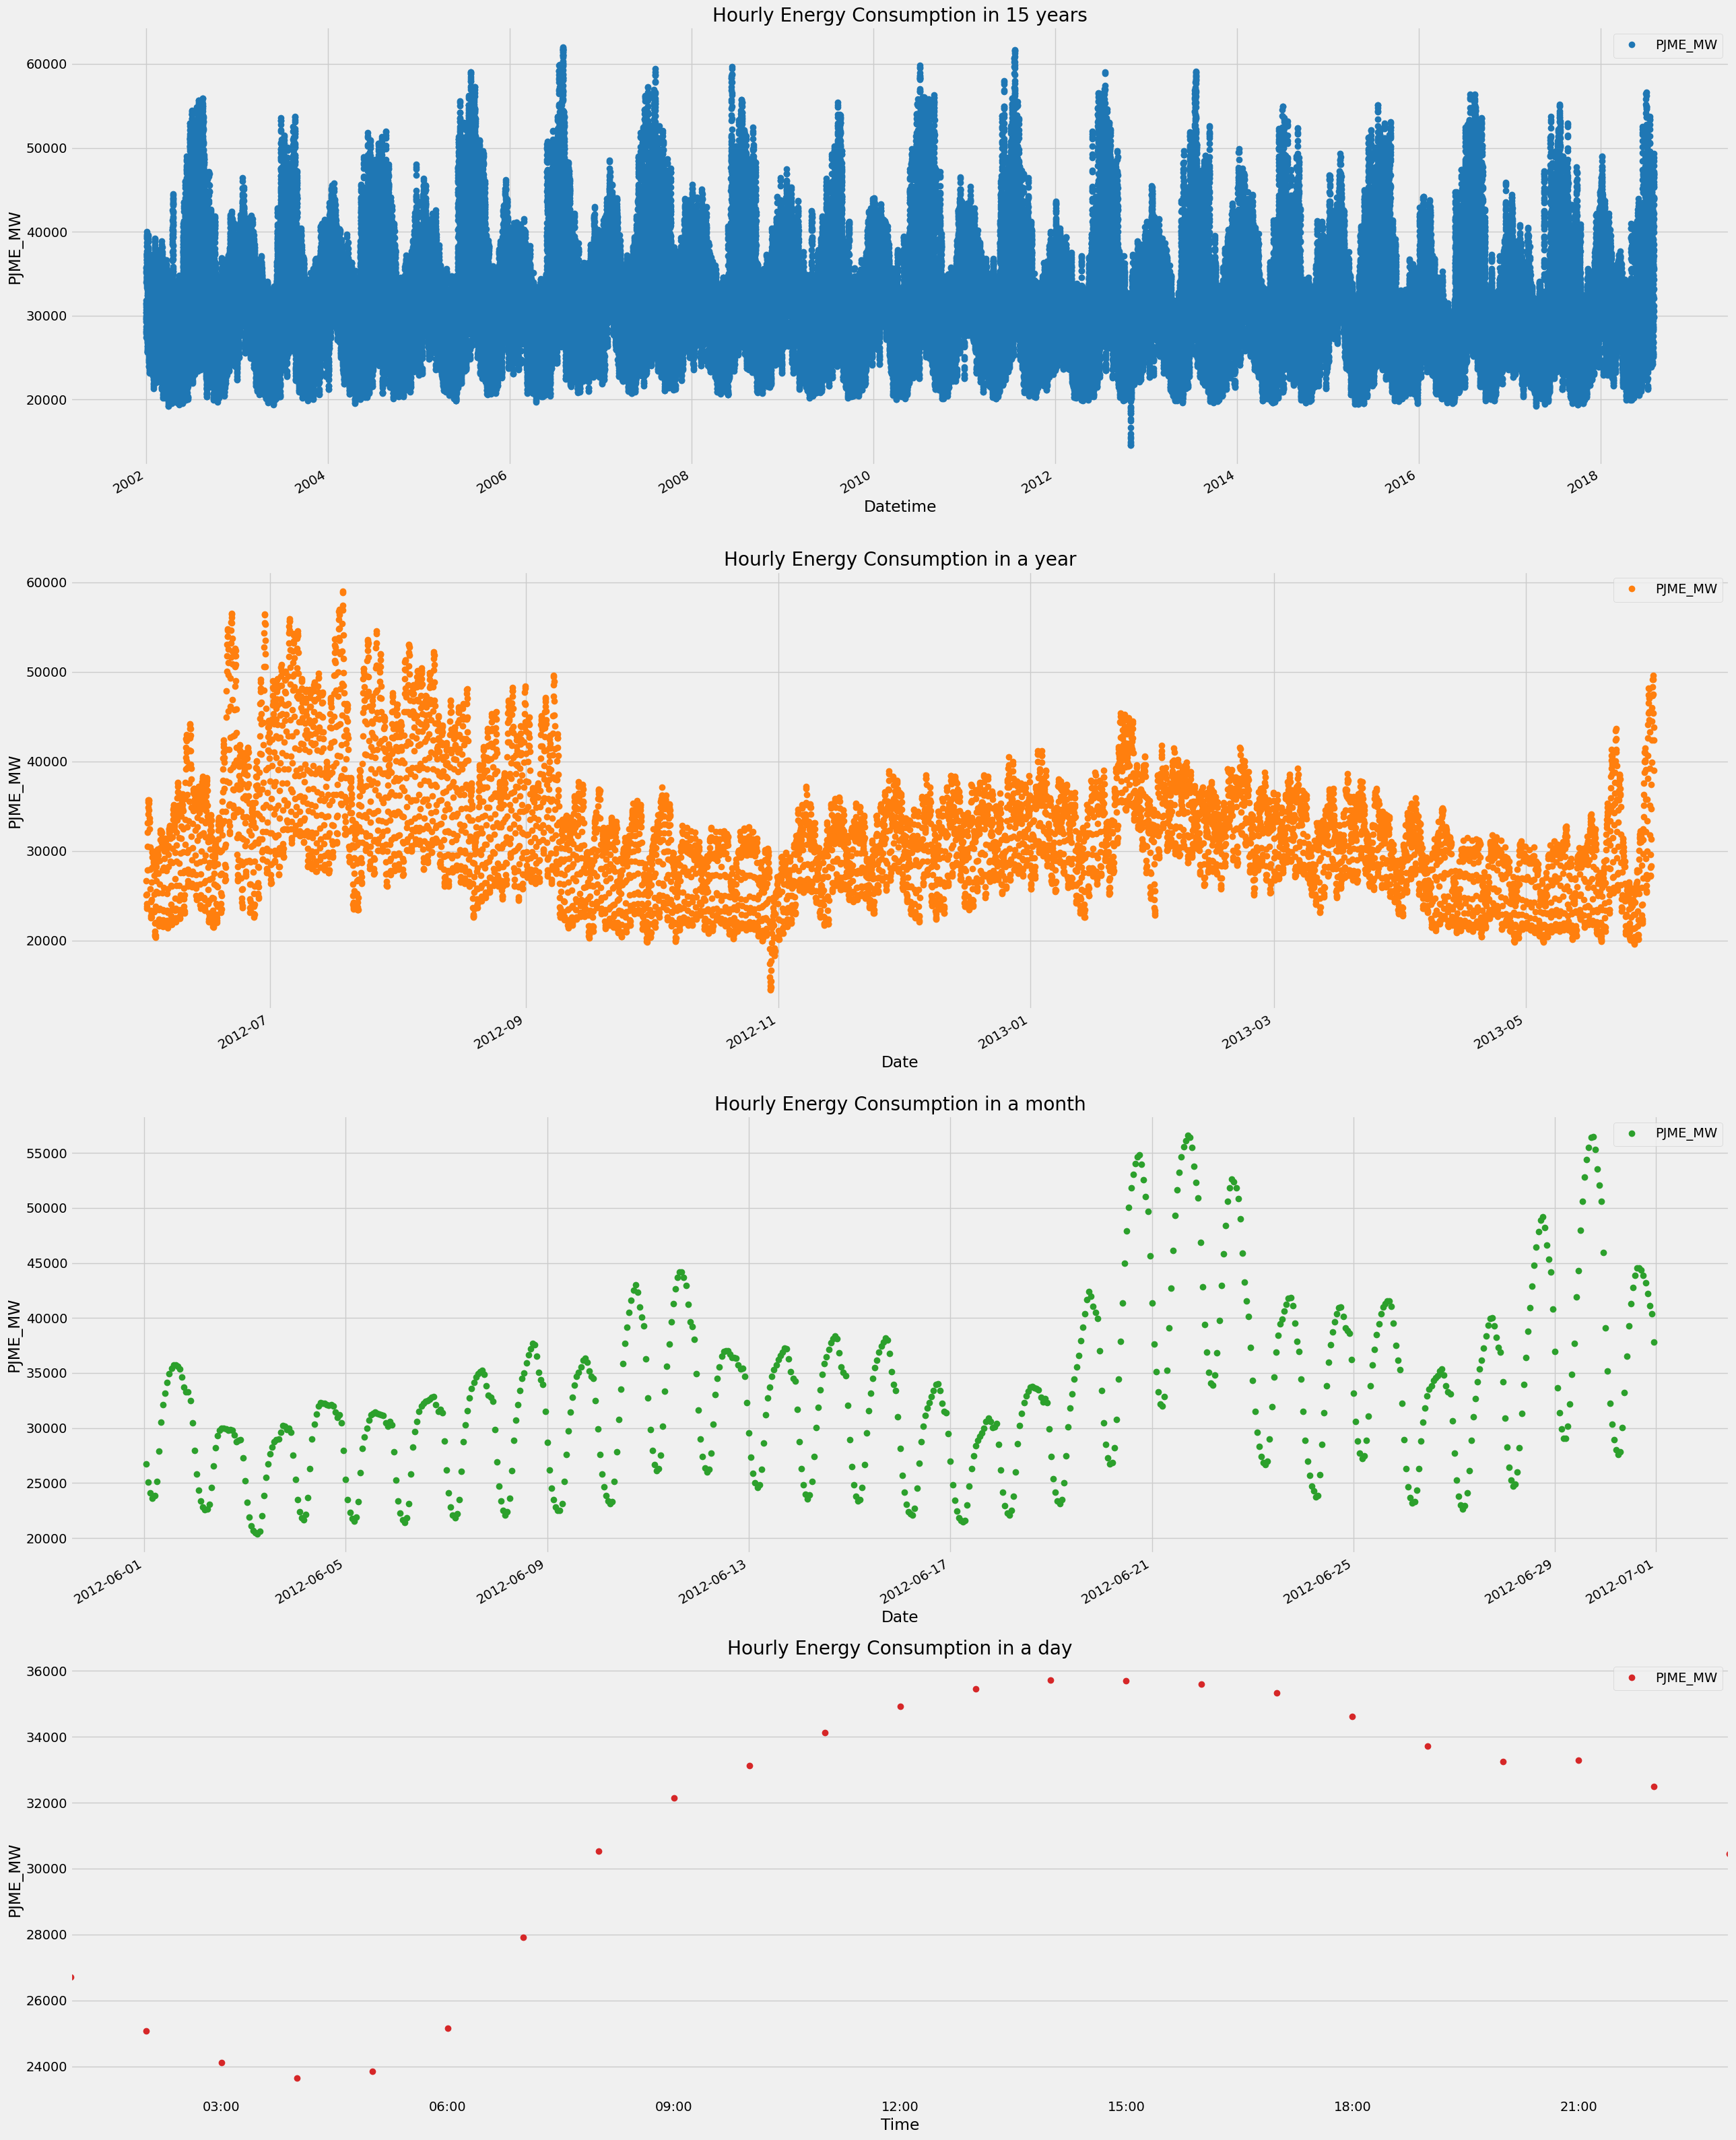

In [13]:
display_hourly_energy_consumption(energy_df, '06-01-2012')

- Eliminate PJME under 19000 MW

In [14]:
print(f'> Shape of energy dataset before handling PJME_MW limits is {energy_df.shape}.')
energy_df = energy_df.query('PJME_MW > 19_000')
print(f'> Shape of energy dataset after handling PJME_MW limits is {energy_df.shape}.')

> Shape of energy dataset before handling PJME_MW limits is (145366, 2).
> Shape of energy dataset after handling PJME_MW limits is (145351, 2).


## Step 5 : Exploratory Data Analysis (EDA)

In [15]:
energy_df.describe()

Datetime        PJME_MW
count                         145351  145351.000000
mean   2010-04-18 01:07:46.919388160   32081.810473
min              2002-01-01 01:00:00   19085.000000
25%              2006-02-23 10:30:00   27575.000000
50%              2010-04-17 21:00:00   31421.000000
75%              2014-06-10 22:30:00   35650.000000
max              2018-08-03 00:00:00   62009.000000
std                              NaN    6462.435417

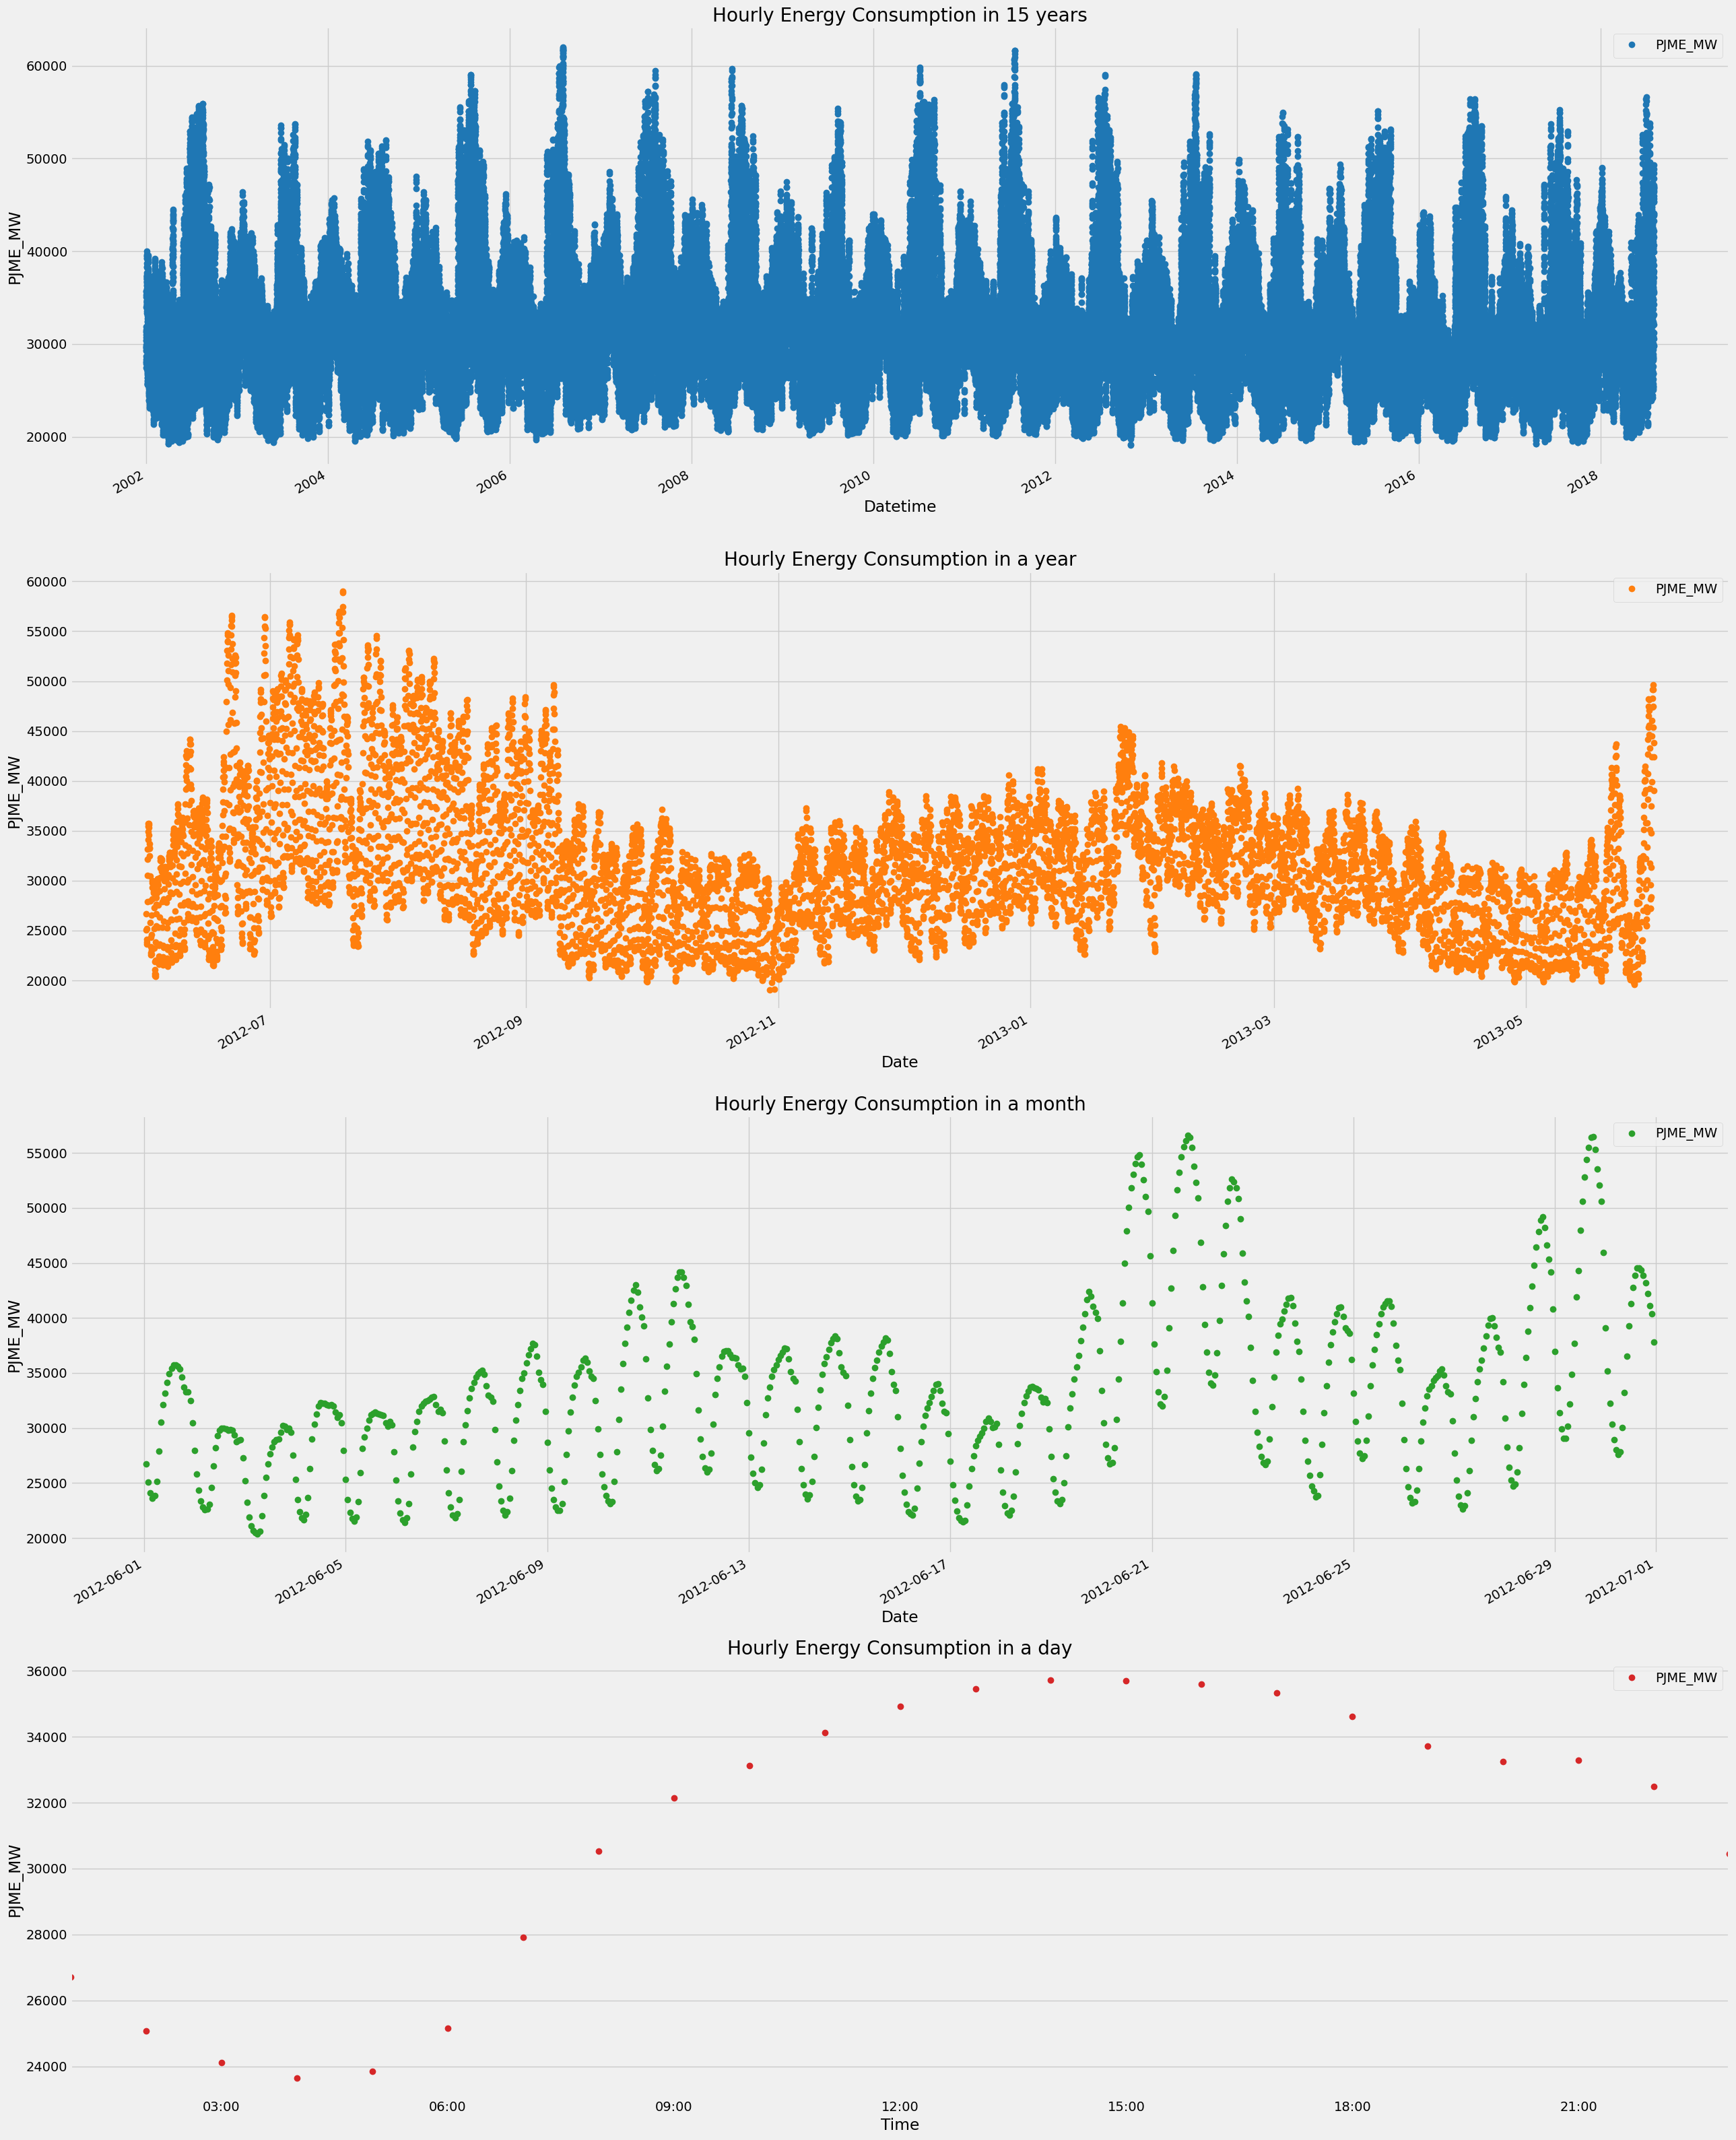

In [16]:
display_hourly_energy_consumption(energy_df, '06-01-2012')

## Step 6 : Save the cleaned dataset

In [17]:
data_dir = r'F:/Python_Projects/AppliedMechineLearningWithPython/Project_10_Energy_Consumption_Prediction/datasets'
# data_dir = '/content/drive/My Drive/Applied Machine Learning/Project 10 : Energy Consumption Prediction/datasets'

data_path = os.path.join(data_dir, 'cleaned_PJME_hourly.csv')
energy_df.to_csv(data_path, index=False)
print(f'> The cleaned energy dataset saved in {data_path}')

> The cleaned energy dataset saved in F:/Python_Projects/AppliedMechineLearningWithPython/Project_10_Energy_Consumption_Prediction/datasets\cleaned_PJME_hourly.csv
